# Построения бейзлайна retrieval-системы на основе датасета MIRACL

**Этапы:**
1. Загрузка и подготовка данных
2. Анализ данных (EDA)
3. BM25 бейзлайн

In [ ]:
!pip install pyarrow==18.1.0 -q
!pip install datasets==2.14.0 sentence-transformers sentencepiece faiss-cpu rank-bm25 pymorphy2 torch tqdm -q
!pip install huggingface_hub -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import gzip
import pickle
import random
import re
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from huggingface_hub import hf_hub_download, list_repo_files
from rank_bm25 import BM25Okapi

random.seed(42)
np.random.seed(42)

## 1. Загрузка данных

In [ ]:
BASE_URL = "https://huggingface.co/datasets/miracl/miracl/resolve/main/miracl-v1.0-ru/"

def load_queries(split: str) -> dict:
    url = f"{BASE_URL}topics/topics.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        queries = {}
        for line in response.text.strip().split('\n')[1:]:
            parts = line.split('\t')
            if len(parts) >= 2:
                queries[parts[0]] = parts[1]
        return queries
    except:
        return {}

def load_qrels(split: str) -> dict:
    url = f"{BASE_URL}qrels/qrels.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        qrels = defaultdict(lambda: {'positive': [], 'negative': []})
        for line in response.text.strip().split('\n'):
            parts = line.split('\t')
            if len(parts) >= 4:
                qid, doc_id, rel = parts[0], parts[2], int(parts[3])
                key = 'positive' if rel > 0 else 'negative'
                qrels[qid][key].append(doc_id)
        return dict(qrels)
    except:
        return {}

def get_required_doc_ids(qrels_dict: dict) -> set:
    doc_ids = set()
    for q in qrels_dict.values():
        doc_ids.update(q.get('positive', []))
        doc_ids.update(q.get('negative', []))
    return doc_ids

In [ ]:
# Загрузка запросов и qrels
dev_queries = load_queries('dev')
dev_qrels = load_qrels('dev')
train_queries = load_queries('train')
train_qrels = load_qrels('train')

test_a_queries = load_queries('test-a')
test_b_queries = load_queries('test-b')
test_queries = {**test_a_queries, **test_b_queries}

all_queries = {**dev_queries, **train_queries, **test_queries}
all_qrels = {**dev_qrels, **train_qrels}
required_doc_ids = get_required_doc_ids(all_qrels)

print(f"Dev: {len(dev_queries)} запросов, {len(dev_qrels)} qrels")
print(f"Train: {len(train_queries)} запросов, {len(train_qrels)} qrels")
print(f"Test: {len(test_queries)} запросов")
print(f"Документов в qrels: {len(required_doc_ids)}")

Dev: 1251 запросов, 1252 qrels
Train: 4682 запросов, 4683 qrels
Test: 1627 запросов
Документов в qrels: 41007


In [ ]:
def load_corpus(target_docs: int = 500_000, seed: int = 42) -> tuple:
    random.seed(seed)

    all_files = list_repo_files("miracl/miracl-corpus", repo_type="dataset")
    jsonl_files = sorted([f for f in all_files if 'ru' in f and f.endswith('.jsonl.gz')])
    docs_per_file = target_docs // len(jsonl_files)

    corpus = {}
    doc_ids = []
    passages = []

    for jsonl_file in tqdm(jsonl_files, desc="Загрузка корпуса"):
        try:
            file_path = hf_hub_download(
                repo_id="miracl/miracl-corpus",
                filename=jsonl_file,
                repo_type="dataset"
            )

            file_docs = []
            required_docs = []

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    if not line.strip():
                        continue
                    item = json.loads(line)
                    doc = {
                        'docid': item['docid'],
                        'title': item['title'],
                        'text': item['text'],
                        'full_text': f"{item['title']}. {item['text']}"
                    }

                    if item['docid'] in required_doc_ids:
                        required_docs.append(doc)
                    else:
                        file_docs.append(doc)

            sample_size = min(docs_per_file, len(file_docs))
            selected = random.sample(file_docs, sample_size) if file_docs else []
            all_selected = selected + required_docs

            for doc in all_selected:
                if doc['docid'] not in corpus:
                    corpus[doc['docid']] = {
                        'title': doc['title'],
                        'text': doc['text'],
                        'full_text': doc['full_text']
                    }
                    doc_ids.append(doc['docid'])
                    passages.append(doc['full_text'])

        except Exception as e:
            print(f"Ошибка: {e}")
            continue

    return corpus, doc_ids, passages

corpus, doc_ids, passages = load_corpus(target_docs=500_000)
print(f"\nЗагружено документов: {len(corpus):,}")

Загрузка корпуса:   0%|          | 0/20 [00:00<?, ?it/s]

miracl-corpus-v1.0-ru/docs-0.jsonl.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-1.jsonl.gz:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-10.jsonl.gz:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-11.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-12.jsonl.gz:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-13.jsonl.gz:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-14.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-15.jsonl.gz:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-16.jsonl.gz:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-17.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-18.jsonl.gz:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-19.jsonl.gz:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-2.jsonl.gz:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-3.jsonl.gz:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-4.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-5.jsonl.gz:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-6.jsonl.gz:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-7.jsonl.gz:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-8.jsonl.gz:   0%|          | 0.00/74.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-9.jsonl.gz:   0%|          | 0.00/73.5M [00:00<?, ?B/s]


Загружено документов: 541,007


In [ ]:
# Проверка покрытия qrels
corpus_set = set(doc_ids)
qrels_docs = get_required_doc_ids(all_qrels)
coverage = len(qrels_docs & corpus_set) / len(qrels_docs) * 100

print(f"Покрытие qrels: {coverage:.1f}%")
assert coverage > 99, f"Покрытие qrels только {coverage:.1f}%!"

Покрытие qrels: 100.0%


## 2. Анализ данных (EDA)

In [ ]:
doc_lengths = [len(p) for p in passages]
query_lengths = [len(q) for q in dev_queries.values()]
pos_counts = [len(q['positive']) for q in dev_qrels.values()]

print("Документы:")
print(f"  Мин: {min(doc_lengths):,}, Макс: {max(doc_lengths):,}")
print(f"  Среднее: {np.mean(doc_lengths):,.0f}, Медиана: {np.median(doc_lengths):,.0f}")

print("\nЗапросы:")
print(f"  Мин: {min(query_lengths)}, Макс: {max(query_lengths)}")
print(f"  Среднее: {np.mean(query_lengths):.0f}")

print("\nРелевантных документов на запрос:")
print(f"  Среднее: {np.mean(pos_counts):.2f}, Макс: {max(pos_counts)}")

Документы:
  Мин: 7, Макс: 12,428
  Среднее: 363, Медиана: 265

Запросы:
  Мин: 15, Макс: 108
  Среднее: 44

Релевантных документов на запрос:
  Среднее: 2.84, Макс: 12


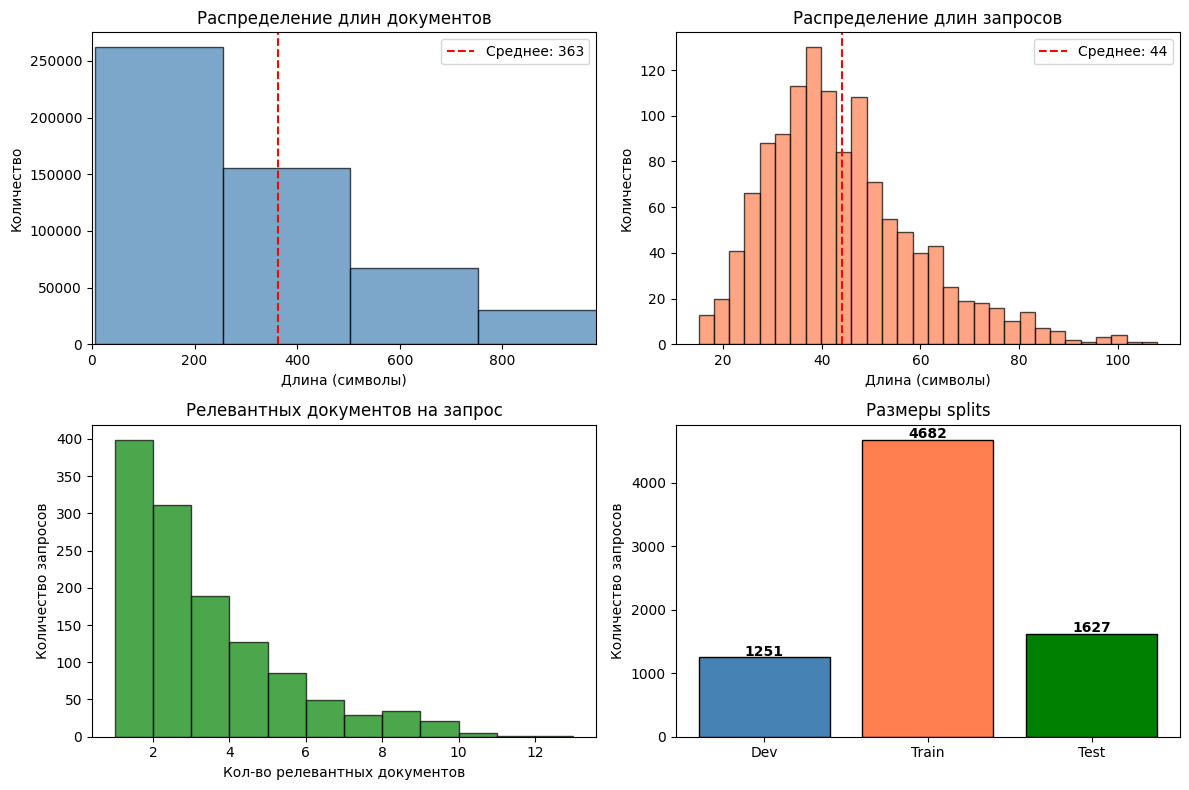

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Распределение длин документов
axes[0, 0].hist(doc_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(doc_lengths):.0f}')
axes[0, 0].set_xlabel('Длина (символы)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].set_title('Распределение длин документов')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, np.percentile(doc_lengths, 95))

# Распределение длин запросов
axes[0, 1].hist(query_lengths, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(query_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(query_lengths):.0f}')
axes[0, 1].set_xlabel('Длина (символы)')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].set_title('Распределение длин запросов')
axes[0, 1].legend()

# Количество релевантных документов
axes[1, 0].hist(pos_counts, bins=range(1, max(pos_counts)+2), color='green', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Кол-во релевантных документов')
axes[1, 0].set_ylabel('Количество запросов')
axes[1, 0].set_title('Релевантных документов на запрос')

# Размеры splits
splits = ['Dev', 'Train', 'Test']
sizes = [len(dev_queries), len(train_queries), len(test_queries)]
axes[1, 1].bar(splits, sizes, color=['steelblue', 'coral', 'green'], edgecolor='black')
axes[1, 1].set_ylabel('Количество запросов')
axes[1, 1].set_title('Размеры splits')
for i, v in enumerate(sizes):
    axes[1, 1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Примеры запросов и ответов
print("Примеры запросов:\n")
for i, (qid, query) in enumerate(list(dev_queries.items())[:5]):
    print(f"{i+1}. {query}")
    if qid in dev_qrels and dev_qrels[qid]['positive']:
        doc_id = dev_qrels[qid]['positive'][0]
        if doc_id in corpus:
            print(f"   → {corpus[doc_id]['title']}")
    print()

Примеры запросов:

1. Как называлась Симбирская губерния с 1924?
   → Симбирская губерния

2. Какое расстояние от Коло́мны до Москвы?
   → Коломна

3. Когда был придуман пряник?
   → Пряник

4. Можно излечиться от наркотической зависимости полностью?
   → Бейерут, Нильс

5. Когда Анна Павлова впервые исполнила партию в балете "Лебединое озеро"?
   → Павлова, Анна Павловна



In [ ]:
# Анализ частотности слов
def tokenize_simple(text: str) -> list:
    return re.findall(r'\b\w+\b', text.lower())

sample_passages = random.sample(passages, min(50000, len(passages)))
all_words = []
for p in sample_passages:
    all_words.extend(tokenize_simple(p))

word_counts = Counter(all_words)

print(f"Уникальных слов: {len(word_counts):,}")
print(f"Всего слов: {len(all_words):,}")
print(f"\nТоп-15 слов:")
for word, count in word_counts.most_common(15):
    print(f"  {word}: {count:,}")

Уникальных слов: 277,424
Всего слов: 2,484,540

Топ-15 слов:
  в: 123,045
  и: 69,348
  на: 36,570
  с: 28,237
  года: 19,371
  по: 17,922
  году: 14,666
  из: 13,223
  был: 10,697
  не: 10,565
  к: 10,428
  а: 10,073
  что: 9,366
  от: 8,996
  его: 8,377


## 3. BM25 бейзлайн

In [ ]:
class SimpleBM25:
    def __init__(self):
        self.bm25 = None
        self.doc_ids = None
        self.passages = None

    def tokenize(self, text: str) -> list:
        return re.findall(r'\b\w{2,}\b', text.lower())

    def fit(self, doc_ids: list, passages: list):
        self.doc_ids = doc_ids
        self.passages = passages
        tokenized = [self.tokenize(p) for p in tqdm(passages, desc="Токенизация")]
        self.bm25 = BM25Okapi(tokenized)
        print(f"Индекс построен: {len(doc_ids):,} документов")

    def search(self, query: str, top_k: int = 10) -> list:
        tokens = self.tokenize(query)
        scores = self.bm25.get_scores(tokens)
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [{
            'doc_id': self.doc_ids[i],
            'score': float(scores[i]),
            'passage': self.passages[i]
        } for i in top_idx]

In [ ]:
# =============================================================================
# ЯЧЕЙКА 12: Простой BM25 бейзлайн
# =============================================================================
from rank_bm25 import BM25Okapi
import re

class SimpleBM25:
    """Простой BM25 бейзлайн"""

    def __init__(self):
        self.bm25 = None
        self.doc_ids = None
        self.passages = None

    def tokenize(self, text: str) -> list:
        """Простая токенизация: lowercase + split по словам"""
        return re.findall(r'\b\w{2,}\b', text.lower())

    def fit(self, doc_ids: list, passages: list):
        """Построение индекса"""
        print("🔨 Построение BM25 индекса...")
        self.doc_ids = doc_ids
        self.passages = passages

        # Токенизация
        tokenized = [self.tokenize(p) for p in tqdm(passages, desc="Токенизация")]

        # BM25
        self.bm25 = BM25Okapi(tokenized)
        print(f"✅ Индекс построен: {len(doc_ids):,} документов")

    def search(self, query: str, top_k: int = 10) -> list:
        """Поиск"""
        tokens = self.tokenize(query)
        scores = self.bm25.get_scores(tokens)
        top_idx = np.argsort(scores)[::-1][:top_k]

        return [{
            'doc_id': self.doc_ids[i],
            'score': float(scores[i]),
            'passage': self.passages[i]
        } for i in top_idx]

print("✅ Класс SimpleBM25 определён")

✅ Класс SimpleBM25 определён


In [ ]:
bm25 = SimpleBM25()

start = time.time()
bm25.fit(doc_ids, passages)
print(f"Время: {time.time() - start:.1f} сек")

Токенизация:   0%|          | 0/541007 [00:00<?, ?it/s]

Индекс построен: 541,007 документов
Время: 33.8 сек


In [ ]:
# Тестовые запросы
test_questions = [
    "Кто такой Юрий Гагарин?",
    "Столица России",
    "Кто написал Войну и мир?"
]

for q in test_questions:
    print(f"\n{q}")
    result = bm25.search(q, top_k=1)[0]
    print(f"  → {result['passage'][:120]}...")


Кто такой Юрий Гагарин?
  → Гагарин, Юрий Алексеевич. 12 апреля 1961 года Юрий Гагарин стал первым человеком в мировой истории, совершившим полёт в ...

Столица России
  → Столицы России. В 1712 году по воле Петра I столица России была перенесена в Санкт-Петербург, специально основанный как ...

Кто написал Войну и мир?
  → Милн, Алан Александр. Милн участвовал в Первой мировой войне в качестве офицера британской армии. Он работал на MI7 — пр...


## 4. Оценка качества

In [ ]:
def evaluate_retriever(retriever, queries: dict, qrels: dict, k_values: list = [1, 5, 10, 20, 100]):
    metrics = defaultdict(list)
    indexed_docs = set(retriever.doc_ids)

    for qid, query_text in tqdm(queries.items(), desc="Оценка"):
        if qid not in qrels:
            continue

        relevant = [d for d in qrels[qid]['positive'] if d in indexed_docs]
        if not relevant:
            continue

        results = retriever.search(query_text, top_k=max(k_values))
        retrieved = [r['doc_id'] for r in results]

        for k in k_values:
            recall = len(set(retrieved[:k]) & set(relevant)) / len(relevant)
            metrics[f'Recall@{k}'].append(recall)

        mrr = 0
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in set(relevant):
                mrr = 1 / rank
                break
        metrics['MRR'].append(mrr)

        rel_set = set(relevant)
        dcg = sum(1/np.log2(i+2) for i, d in enumerate(retrieved[:10]) if d in rel_set)
        idcg = sum(1/np.log2(i+2) for i in range(min(10, len(relevant))))
        metrics['NDCG@10'].append(dcg / idcg if idcg > 0 else 0)

    return {k: np.mean(v) for k, v in metrics.items()}

In [ ]:
dev_metrics = evaluate_retriever(bm25, dev_queries, dev_qrels)

print("Результаты BM25 (dev):")
print("-" * 30)
for metric, value in sorted(dev_metrics.items()):
    print(f"{metric}: {value:.4f}")

Оценка:   0%|          | 0/1251 [00:00<?, ?it/s]

Результаты BM25 (dev):
------------------------------
MRR: 0.3855
NDCG@10: 0.3072
Recall@1: 0.1301
Recall@10: 0.3747
Recall@100: 0.6052
Recall@20: 0.4591
Recall@5: 0.2883


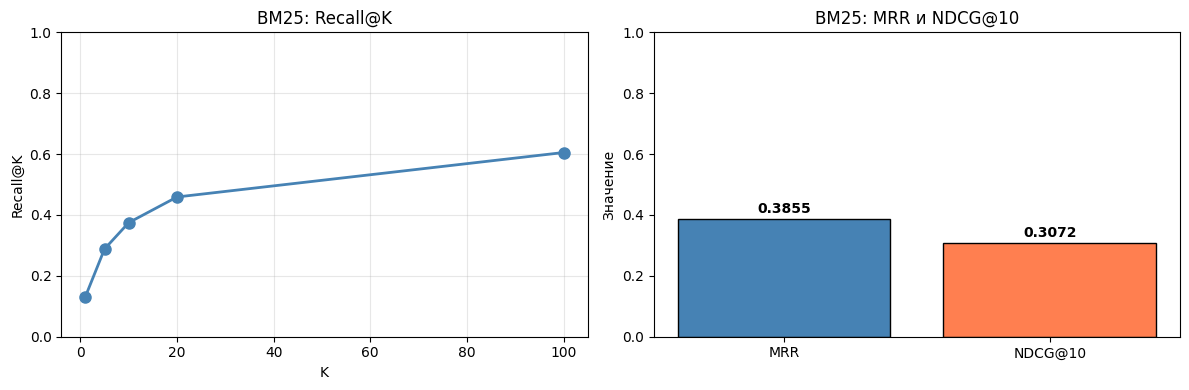

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

k_values = [1, 5, 10, 20, 100]
recalls = [dev_metrics[f'Recall@{k}'] for k in k_values]

axes[0].plot(k_values, recalls, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Recall@K')
axes[0].set_title('BM25: Recall@K')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

metrics_names = ['MRR', 'NDCG@10']
values = [dev_metrics['MRR'], dev_metrics['NDCG@10']]
bars = axes[1].bar(metrics_names, values, color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('Значение')
axes[1].set_title('BM25: MRR и NDCG@10')
axes[1].set_ylim(0, 1)

for bar, val in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('baseline_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Сохранение данных

In [ ]:
data_to_save = {
    'corpus': corpus,
    'doc_ids': doc_ids,
    'passages': passages,
    'dev_queries': dev_queries,
    'dev_qrels': dev_qrels,
    'train_queries': train_queries,
    'train_qrels': train_qrels,
    'test_queries': test_queries,
    'baseline_metrics': dev_metrics
}

with open('miracl_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Данные сохранены: miracl_data.pkl ({os.path.getsize('miracl_data.pkl') / 1024 / 1024:.1f} MB)")

Данные сохранены: miracl_data.pkl (698.7 MB)


## Итоги

| Метрика | BM25 |
|---------|------|
| MRR | 0.3855 |
| Recall@10 | 0.3747 |
| NDCG@10 | 0.3072 |

**Следующие шаги:**
- BPE токенизация для BM25
- Dense Retriever
- Hybrid подход
- reranker
- дообучение

In [ ]:
print(f"""
Итоги:
  Документов: {len(corpus):,}
  Запросов (dev): {len(dev_queries)}

BM25 Baseline:
  MRR:       {dev_metrics['MRR']:.4f}
  Recall@10: {dev_metrics['Recall@10']:.4f}
  NDCG@10:   {dev_metrics['NDCG@10']:.4f}
""")


Итоги:
  Документов: 541,007
  Запросов (dev): 1251
  
BM25 Baseline:
  MRR:       0.3855
  Recall@10: 0.3747
  NDCG@10:   0.3072

